# Importing Packages

In [2]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.9 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [101]:
import spacy
from spacy import displacy
from spacy.tokens import DocBin
from spacy.util import filter_spans
from spacy.pipeline import EntityRuler
from tqdm import tqdm

import re
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Data Loading and Exploring

In [5]:
def load_data(name):
    tokens = []
    labels = []
    sentence_tokens = []
    sentence_labels = []
    tokens_count = 0
    with open(f"/kaggle/input/conll003-englishversion/{name}.txt") as f:
        for line in f.readlines():
            if line.startswith("-DOCSTART-"):
                continue
            words = line.split(" ")
            first = words[0]
            if first.startswith("\n") and len(sentence_tokens) > 0:
                sentence_tokens.pop(0)
                sentence_labels.pop(0)
                tokens.append(sentence_tokens)
                labels.append(sentence_labels)
                sentence_tokens = []
                sentence_labels = []
            if first == "":
                continue
            label = words[len(words)-1]
            sentence_tokens.append(first.strip())
            sentence_labels.append(label.strip())
            tokens_count += 1
    return tokens, labels, tokens_count

In [6]:
train_tokens, train_labels, train_count = load_data("train")
val_tokens, val_labels, val_count = load_data("valid")
test_tokens, test_labels, test_count = load_data("test")

In [7]:
print(train_tokens[0])
print(train_labels[0])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [8]:
print(" ".join(train_tokens[0]))
print(" ".join(train_labels[0]))

EU rejects German call to boycott British lamb .
B-ORG O B-MISC O O O B-MISC O O


In [9]:
print(f"Total Train Tokens: {train_count}")
train_sentences_count = len(train_tokens)
print(f"Total Train Sentences: {train_sentences_count}")

Total Train Tokens: 218608
Total Train Sentences: 14986


In [10]:
print(f"Total Validation Tokens: {val_count}")
val_sentences_count = len(val_tokens)
print(f"Total Validation Sentences: {val_sentences_count}")

Total Validation Tokens: 54828
Total Validation Sentences: 3465


In [11]:
print(f"Total Validation Tokens: {test_count}")
test_sentences_count = len(test_tokens)
print(f"Total Validation Sentences: {test_sentences_count}")

Total Validation Tokens: 50119
Total Validation Sentences: 3683


# Exploring pretrained scapy model: en_core_web_lg

In [85]:
lg_model = spacy.load("en_core_web_lg")

In [86]:
sentences_sample = [" ".join(x) for x in train_tokens[0:5]]
sample_docs = [lg_model(x) for x in sentences_sample]
print(sample_docs[0])
print(type(sample_docs[0]))

EU rejects German call to boycott British lamb .
<class 'spacy.tokens.doc.Doc'>


In [87]:
for i, doc in enumerate(sample_docs):
    print(f"Sentence[{i}]: {doc}")
    print(f"Entities[{i}]: {doc.ents}")

Sentence[0]: EU rejects German call to boycott British lamb .
Entities[0]: (EU, German, British)
Sentence[1]: Peter Blackburn
Entities[1]: (Peter Blackburn,)
Sentence[2]: BRUSSELS 1996-08-22
Entities[2]: (BRUSSELS, 1996-08-22)
Sentence[3]: The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .
Entities[3]: (The European Commission, Thursday, German, British)
Sentence[4]: Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .
Entities[4]: (Germany, the European Union 's, Werner Zwingmann, Wednesday, Britain)


# Visualizing pretrained en_core_web_lg using displacy 

In [88]:
for doc in sample_docs:
    displacy.render(doc, style="ent", jupyter= True)

# Exploring pretrained scapy model: en_core_web_sm

In [89]:
sm_model = spacy.load("en_core_web_sm")

In [90]:
sentences_sample = [" ".join(x) for x in train_tokens[0:5]]
sample_docs = [sm_model(x) for x in sentences_sample]
print(sample_docs[0])
print(type(sample_docs[0]))

EU rejects German call to boycott British lamb .
<class 'spacy.tokens.doc.Doc'>


In [91]:
for doc in sample_docs:
    displacy.render(doc, style="ent", jupyter= True)

# Train a Custom Scapy Model on my data

In [142]:
my_model = spacy.blank("en")
doc_bin = DocBin()

In [143]:
sentence_index = 0
for sentence in tqdm(train_tokens):
    sentence = " ".join(sentence)
    sentence = sentence.replace("-","_")
    doc = my_model.make_doc(sentence)
    ents = []
    word_start_index = 0
    word_end_index = 0
    try:
        for word_index, word in enumerate(doc):
            word_tag = train_labels[sentence_index][word_index]
            if(word_tag == "O"):
                continue
    
            if word_end_index != 0:
                text = doc.text[word_end_index-1:]
                word_start_index = text.index(word.text) + word_end_index - 1
            else:
                word_start_index = doc.text.index(word.text)
            word_end_index = word_start_index + len(word.text)
            
            span = doc.char_span(word_start_index,word_end_index,label= word_tag)
            if span is None:
                print("Skipping non-span")
            else:
                ents.append(span)
    except:
        sentence_index=sentence_index+1
        continue
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)
    sentence_index=sentence_index+1

  8%|▊         | 1245/14986 [00:00<00:04, 3250.65it/s]

Skipping non-span


 20%|██        | 3039/14986 [00:00<00:03, 3230.17it/s]

Skipping non-span
Skipping non-span
Skipping non-span


 36%|███▋      | 5456/14986 [00:01<00:02, 4008.68it/s]

Skipping non-span


 53%|█████▎    | 7935/14986 [00:02<00:01, 4176.55it/s]

Skipping non-span
Skipping non-span
Skipping non-span


 62%|██████▏   | 9294/14986 [00:02<00:01, 4195.20it/s]

Skipping non-span


 78%|███████▊  | 11627/14986 [00:03<00:00, 3477.06it/s]

Skipping non-span
Skipping non-span
Skipping non-span


 84%|████████▍ | 12619/14986 [00:03<00:00, 3086.20it/s]

Skipping non-span


100%|██████████| 14986/14986 [00:04<00:00, 3534.89it/s]

Skipping non-span


In [144]:
doc_bin.to_disk("train.spacy")

In [145]:
val_bin = DocBin()
sentence_index = 0
for sentence in tqdm(val_tokens):
    sentence = " ".join(sentence)
    sentence = sentence.replace("-","_")
    doc = my_model.make_doc(sentence)
    ents = []
    word_start_index = 0
    word_end_index = 0
    try:
        for word_index, word in enumerate(doc):
            word_tag = val_labels[sentence_index][word_index]
            if(word_tag == "O"):
                continue
    
            if word_end_index != 0:
                text = doc.text[word_end_index-1:]
                word_start_index = text.index(word.text) + word_end_index - 1
            else:
                word_start_index = doc.text.index(word.text)
            word_end_index = word_start_index + len(word.text)
            
            span = doc.char_span(word_start_index,word_end_index,label= word_tag)
            if span is None:
                print("Skipping non-span")
            else:
                ents.append(span)
    except:
        sentence_index=sentence_index+1
        continue
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    val_bin.add(doc)
    sentence_index=sentence_index+1

 62%|██████▏   | 2144/3465 [00:00<00:00, 4207.94it/s]

Skipping non-span
Skipping non-span
Skipping non-span


100%|██████████| 3465/3465 [00:00<00:00, 3852.59it/s]

Skipping non-span
Skipping non-span
Skipping non-span
Skipping non-span


In [146]:
val_bin.to_disk("val.spacy")

In [147]:
test_bin = DocBin()
sentence_index = 0
for sentence in tqdm(test_tokens):
    sentence = " ".join(sentence)
    sentence = sentence.replace("-","_")
    doc = my_model.make_doc(sentence)
    ents = []
    word_start_index = 0
    word_end_index = 0
    try:
        for word_index, word in enumerate(doc):
            word_tag = test_labels[sentence_index][word_index]
            if(word_tag == "O"):
                continue
    
            if word_end_index != 0:
                text = doc.text[word_end_index-1:]
                word_start_index = text.index(word.text) + word_end_index - 1
            else:
                word_start_index = doc.text.index(word.text)
            word_end_index = word_start_index + len(word.text)
            
            span = doc.char_span(word_start_index,word_end_index,label= word_tag)
            if span is None:
                print("Skipping non-span")
            else:
                ents.append(span)
    except:
        sentence_index=sentence_index+1
        continue
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    test_bin.add(doc)
    sentence_index=sentence_index+1

 57%|█████▋    | 2084/3683 [00:00<00:00, 3432.49it/s]

Skipping non-span
Skipping non-span


100%|██████████| 3683/3683 [00:00<00:00, 3729.95it/s]


In [148]:
test_bin.to_disk("test.spacy")

In [149]:
!python -m spacy init fill-config "/kaggle/input/ner-spacy-base-config/base_config.cfg" "/kaggle/working/config.cfg"

✔ Auto-filled config with all values
✔ Saved config
/kaggle/working/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [150]:
!python -m spacy train "/kaggle/working/config.cfg" --output ./ --paths.train "/kaggle/working/train.spacy" --paths.dev "/kaggle/working/val.spacy" 

ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2025-08-22 01:00:10,259] [INFO] Set up nlp object from config
[2025-08-22 01:00:10,284] [INFO] Pipeline: ['tok2vec', 'ner']
[2025-08-22 01:00:10,288] [INFO] Created vocabulary
[2025-08-22 01:00:12,860] [INFO] Added vectors: en_core_web_lg
[2025-08-22 01:00:12,860] [INFO] Finished initializing nlp object
[2025-08-22 01:00:19,858] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
/usr/local/lib/python3.11/dist-packages/thinc/layers/layernorm.py:31: RuntimeWarning: divide by zero encountered in reciprocal
  d_xhat = N * dY - sum_dy - dist * var ** (-1.0) * sum_dy_dis

In [155]:
!python -m spacy evaluate "/kaggle/working/model-best" "/kaggle/working/test.spacy" --output "/kaggle/working/metrics.json"

ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   86.56 
NER R   86.87 
NER F   86.71 
SPEED   2528  


=============================== NER (per type) ===============================

             P       R       F
B-LOC    87.34   92.40   89.80
B-PER    89.94   91.50   90.71
I-PER    93.26   96.67   94.93
I-LOC    83.88   82.19   83.03
B-MISC   82.15   82.27   82.21
I-MISC   60.31   72.09   65.68
B-ORG    85.93   79.89   82.80
I-ORG    85.17   80.67   82.86

✔ Saved results to /kaggle/working/metrics.json


In [156]:
!zip -r modelbest.zip /kaggle/working/model-best

  adding: kaggle/working/model-best/ (stored 0%)
  adding: kaggle/working/model-best/config.cfg (deflated 60%)
  adding: kaggle/working/model-best/meta.json (deflated 63%)
  adding: kaggle/working/model-best/tokenizer (deflated 81%)
  adding: kaggle/working/model-best/ner/ (stored 0%)
  adding: kaggle/working/model-best/ner/model (deflated 10%)
  adding: kaggle/working/model-best/ner/cfg (deflated 33%)
  adding: kaggle/working/model-best/ner/moves (deflated 72%)
  adding: kaggle/working/model-best/vocab/ (stored 0%)
  adding: kaggle/working/model-best/vocab/vectors.cfg (stored 0%)
  adding: kaggle/working/model-best/vocab/vectors (deflated 8%)
  adding: kaggle/working/model-best/vocab/strings.json (deflated 78%)
  adding: kaggle/working/model-best/vocab/lookups.bin (stored 0%)
  adding: kaggle/working/model-best/vocab/key2row (deflated 11%)
  adding: kaggle/working/model-best/tok2vec/ (stored 0%)
  adding: kaggle/working/model-best/tok2vec/model (deflated 8%)
  adding: kaggle/working/m

In [157]:
!zip -r modellast.zip /kaggle/working/model-last

  adding: kaggle/working/model-last/ (stored 0%)
  adding: kaggle/working/model-last/config.cfg (deflated 60%)
  adding: kaggle/working/model-last/meta.json (deflated 63%)
  adding: kaggle/working/model-last/tokenizer (deflated 81%)
  adding: kaggle/working/model-last/ner/ (stored 0%)
  adding: kaggle/working/model-last/ner/model (deflated 10%)
  adding: kaggle/working/model-last/ner/cfg (deflated 33%)
  adding: kaggle/working/model-last/ner/moves (deflated 72%)
  adding: kaggle/working/model-last/vocab/ (stored 0%)
  adding: kaggle/working/model-last/vocab/vectors.cfg (stored 0%)
  adding: kaggle/working/model-last/vocab/vectors (deflated 8%)
  adding: kaggle/working/model-last/vocab/strings.json (deflated 78%)
  adding: kaggle/working/model-last/vocab/lookups.bin (stored 0%)
  adding: kaggle/working/model-last/vocab/key2row (deflated 11%)
  adding: kaggle/working/model-last/tok2vec/ (stored 0%)
  adding: kaggle/working/model-last/tok2vec/model (deflated 8%)
  adding: kaggle/working/m

In [159]:
my_model = spacy.load("/kaggle/input/ner-from-news-article/model-best/")

In [160]:
doc = my_model("Michael Gamal has been to USA before and he has been to Grand Canyon there.")

colors = {
    "B-LOC": "#ff6961",   # red-ish
    "I-LOC": "#ffb347",   # orange
    "B-ORG": "#77dd77",   # green
    "I-ORG": "#03c03c",   # darker green
    "B-PER": "#779ecb",   # blue
    "I-PER": "#4169e1",   # royal blue
    "B-MISC": "#fdfd96",  # yellow
    "I-MISC": "#cbaacb",  # purple/pink
}
options = {"colors": colors}

spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

# Using Rule-Based NER Approach (from scratch "blank" model)

In [133]:
rule_model = spacy.blank("en")
ruler = rule_model.add_pipe("entity_ruler", config={"overwrite_ents":True})

In [134]:
COUNTRIES = ["United States", "United Kingdom", "Germany", "France", "Egypt", "USA", "UK", "China", "Japan", "Spain", "Italy"]
ORG_SUFFIX = ["inc.", "ltd.", "corp.", "co.", "bank", "university", "college", "group", "committee", "council"]
NATIONALITY_ADJ = ["american","british","german","french","egyptian","chinese","japanese","spanish","italian"]

patterns = (
    [
        {"label": "PER", "pattern": [{"LOWER": {"IN": ["mr.","mrs.","ms.","dr.","prof."]}}, {"IS_TITLE": True, "OP": "+"}]},

        {"label": "PER", "pattern": [{"IS_TITLE": True}, {"IS_TITLE": True, "OP": "+"}]},

        {"label": "ORG", "pattern": [{"IS_TITLE": True, "OP": "+"}, {"LOWER": {"IN": ORG_SUFFIX}}]},

        {"label": "ORG", "pattern": [{"TEXT": {"REGEX": "^[A-Z]{2,6}$"}}]},

        {"label": "LOC", "pattern": [{"LOWER": {"IN": ["in","at","from","to"]}}, {"IS_TITLE": True, "OP": "+"}]},
    ]
    + [{"label": "LOC", "pattern": c} for c in COUNTRIES]
    + [{"label": "MISC", "pattern": [{"LOWER": nat}]} for nat in NATIONALITY_ADJ]
)

In [135]:
ruler.add_patterns(patterns)

In [136]:
doc = rule_model("Michael Gamal has been to USA before and he has been to Grand Canyon and American University there.")

colors = {
    "LOC": "#ff6961",   # red-ish
    "ORG": "#77dd77",   # green
    "PER": "#779ecb",   # blue
    "MISC": "#fdfd96",  # yellow
}
options = {"colors": colors}

spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

# Using Rule-Based NER Approach on Pretrained Model (en_core_web_lg)

In [137]:
pretrained_rule_model = spacy.load("en_core_web_lg")
pretrained_ruler = pretrained_rule_model.add_pipe("entity_ruler")

In [138]:
pretrained_ruler.add_patterns(patterns)

In [139]:
doc = pretrained_rule_model("Michael Gamal has been to USA before and he has been to Grand Canyon and American University there.")

colors = {
    "LOC": "#ff6961",   # red-ish
    "ORG": "#77dd77",   # green
    "PER": "#779ecb",   # blue
    "MISC": "#fdfd96",  # yellow
}
options = {"colors": colors}

spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

In [161]:
def sentence_to_text_and_token_char_spans(tokens):
    text_parts, spans, pos = [], [], 0
    for i, tok in enumerate(tokens):
        if i: text_parts.append(" "); pos += 1
        start = pos
        text_parts.append(tok); pos += len(tok)
        spans.append((start, pos))
    return "".join(text_parts), spans

# --- map spaCy labels -> base labels used in your BIO (PER/ORG/LOC/MISC) ---
def base_label(lbl):
    if lbl in ("PER","PERSON"): return "PER"
    if lbl in ("ORG",):         return "ORG"
    if lbl in ("LOC","GPE"):    return "LOC"
    return "MISC"

# --- convert doc.ents -> BIO per token aligned to your tokens ---
def ents_to_bio_for_tokens(doc, token_spans):
    ents = sorted(filter_spans(list(doc.ents)), key=lambda e: (e.end_char - e.start_char), reverse=True)
    bio = ["O"] * len(token_spans)
    for ent in ents:
        ent_start, ent_end = ent.start_char, ent.end_char
        covered = [i for i,(s,e) in enumerate(token_spans) if s >= ent_start and e <= ent_end]
        if not covered:  # fallback to any overlap
            covered = sorted({i for i,(s,e) in enumerate(token_spans) if not (e <= ent_start or s >= ent_end)})
        b = base_label(ent.label_)
        for j, ti in enumerate(covered):
            if bio[ti] != "O":  # keep earlier longer span
                continue
            bio[ti] = f"{'B' if j==0 else 'I'}-{b}"
    return bio

# --- evaluate any spaCy model against BIO gold ---
def evaluate_bio(nlp, test_tokens, test_labels):
    y_true, y_pred = [], []
    for tokens, gold_bio in zip(test_tokens, test_labels):
        text, tok_spans = sentence_to_text_and_token_char_spans(tokens)
        pred_bio = ents_to_bio_for_tokens(nlp(text), tok_spans)
        m = min(len(pred_bio), len(gold_bio))
        y_true.extend(gold_bio[:m])
        y_pred.extend(pred_bio[:m])
    labels_no_o = sorted({t for t in set(y_true) | set(y_pred) if t != "O"})
    acc = sum(a==b for a,b in zip(y_true,y_pred)) / len(y_true) * 100
    print(f"Overall token accuracy (incl. 'O'): {acc:.2f}%\n")
    return acc

# --- run on your ready models (do NOT redeclare them) ---
print("== en_core_web_lg ==")
lg_acc = evaluate_bio(lg_model, test_tokens, test_labels)

print("== en_core_web_sm ==")
sm_acc = evaluate_bio(sm_model, test_tokens, test_labels)

print("== blank rule_model ==")
rule_acc = evaluate_bio(rule_model, test_tokens, test_labels)

print("== pretrained en_core_web_lg + rule_model ==")
pretrained_rule_acc = evaluate_bio(pretrained_rule_model, test_tokens, test_labels)

print("== my_model ==")
my_model_acc = evaluate_bio(my_model, test_tokens, test_labels)


== en_core_web_lg ==
Overall token accuracy (incl. 'O'): 80.76%

== en_core_web_sm ==
Overall token accuracy (incl. 'O'): 78.99%

== blank rule_model ==
Overall token accuracy (incl. 'O'): 85.25%

== pretrained en_core_web_lg + rule_model ==
Overall token accuracy (incl. 'O'): 79.92%

== my_model ==
Overall token accuracy (incl. 'O'): 83.33%



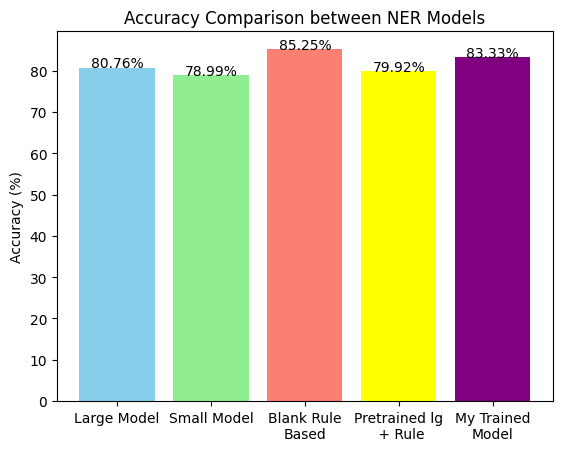

In [170]:
models= ["Large Model", "Small Model", "Blank Rule\nBased","Pretrained lg\n + Rule","My Trained\nModel"]
scores= [lg_acc, sm_acc, rule_acc, pretrained_rule_acc, my_model_acc]
plt.bar(models,scores, color=['skyblue','lightgreen',"salmon","yellow","purple"])
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison between NER Models")

# Show values on bars
for i, v in enumerate(scores):
    plt.text(i, v, f"{v:.2f}%", ha="center")

plt.show()